In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import logging
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r"\usepackage{amsmath}")
plt.rc('font', family='serif')
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
logging.getLogger().setLevel(logging.INFO)

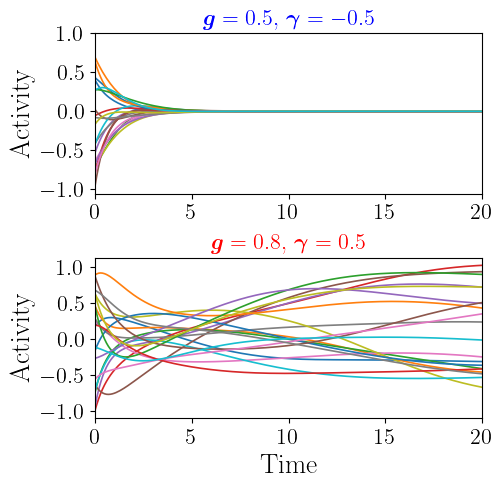

In [11]:
gList = [0.5, 0.8]
gammaLists = [-0.5, 0.5]
fig, ax = plt.subplots(2, 1, figsize=(5, 5), gridspec_kw={
    "hspace": 0.4
})
colors = ["blue", "red"]
i = 0
for g, gamma in zip(gList, gammaLists):
    N = 1000
    k = math.sqrt((1 - gamma) / (1 + gamma))
    x = (torch.rand(size=(N, ), device=device) - 0.5) * 2
    Js = torch.normal(0, g/math.sqrt(N * (1 + k**2)), size=(N, N), device=device)
    Js = (Js + Js.t()) / math.sqrt(2)
    Ja = torch.normal(0, g/math.sqrt(N * (1 + k**2)), size=(N, N), device=device)
    Ja = (Ja - Ja.t()) / math.sqrt(2)
    J = Js + k * Ja
    # J = J - torch.diag_embed(torch.diag(J))
    dt = 0.1
    phi = torch.tanh
    xList = [x.clone()]
    numIteration = 200
    for _ in range(numIteration):
        x = x + (-x + torch.mv(J, phi(x))) * dt
        xList.append(x.clone())
    xList = torch.stack(xList, dim=1).cpu()

    timeList = torch.arange(0, (numIteration + 1) * dt, dt)[:numIteration+1]
    for j in range(20):
        ax[i].plot(timeList, xList[j], linewidth=1.2)
    if i == 1:
        ax[i].set_xlabel("Time", fontsize=20)
    ax[i].set_ylabel("Activity", fontsize=20)
    ax[i].set_xticks(torch.linspace(0, numIteration * dt, 5, dtype=torch.int32))
    ax[i].set_yticks(torch.linspace(-1, 1, 5))
    ax[i].set_title("$\\boldsymbol{{g}}={:.1f}, \, \\boldsymbol{{\\gamma}}={:.1f}$".format(g, gamma), fontsize=16, color=colors[i])
    ax[i].tick_params(labelsize=16)
    ax[i].set_xlim((0, numIteration * dt))

    i += 1

# plt.savefig("../../Data/figures/fig1-simulation.pdf", bbox_inches="tight")
plt.show()
plt.close()

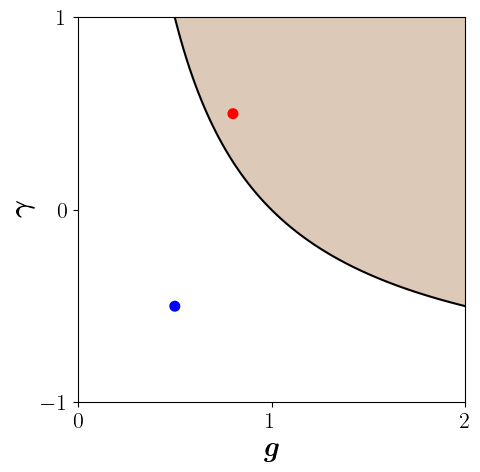

In [3]:
gList = torch.linspace(0.5, 2.0, 100)
gammaLists = 1 / gList - 1
plt.figure(figsize=(5, 5))
plt.plot(gList, gammaLists, color="black")
plt.fill_between(gList, gammaLists, 1, facecolor='#DDC9B7')
plt.scatter([0.5, 0.8], [-0.5, 0.5], s=48, color=["blue", "red"])
plt.xlabel("$\\boldsymbol{g}$", fontsize=20)
plt.xticks([0, 1, 2], fontsize=16)
plt.yticks([-1, 0, 1], fontsize=16)
plt.ylabel("$\\boldsymbol{\\gamma}$", fontsize=20)
plt.xlim((0, 2))
plt.ylim((-1, 1))
# plt.savefig("../../Data/figures/fig1-phaseDiagram.pdf", bbox_inches="tight")
plt.show()
plt.close()

tensor([0.8713+0.0000j, 0.0180+0.9140j, 0.0180-0.9140j])
tensor([ 2.1305+0.0000j, -1.0653+2.4656j, -1.0653-2.4656j])


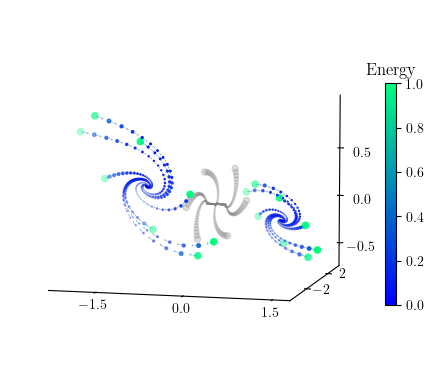

In [18]:
N = 3
eta = 0
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.view_init(6, -75, 0)
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# plt.axis("off")
J = torch.tensor([[0.6226, -0.4622,  0.2945],
    [-0.2913,  0.3212,  1.1663],
    [-0.3463, -0.6295, -0.0364]])
print(torch.linalg.eigvals(J))
xFixedPoint = torch.zeros(size=(3, ))
xBeginPoint = torch.tensor([-0.3613,  0.2119, -0.3709])
# xBeginPoint = (torch.rand(size=(3, )) - 0.5)
xSecondPoint = torch.tensor([-0.3685,  0.0954, -0.2623])
normalAxis = torch.linalg.cross(xBeginPoint - xSecondPoint, xFixedPoint - xSecondPoint)
phi = torch.tanh

numLines = 6
rotate = torch.matrix_exp(torch.linalg.cross(torch.eye(3), (normalAxis / torch.linalg.norm(normalAxis) * (torch.pi * 2 / numLines)).unsqueeze(dim=0)))
for t in range(numLines):
    dt = 0.1
    # x = torch.normal(xFixedPoint1, torch.ones_like(xFixedPoint1))
    x = xBeginPoint
    xList = [x.clone()]
    E = torch.sum((-x + torch.mv(J, x))**2 / 2 + eta * (x**2), dim=0)
    EList = [E.clone()]
    numIteration = 150
    for i in range(numIteration):
        x = x + (-x + torch.mv(J, phi(x))) * dt
        xList.append(x.clone())

        E = torch.sum((-x + torch.mv(J, phi(x)))**2 / 2 + eta * (x**2), dim=0)
        EList.append(E.clone())

    # print(x, torch.norm(x), E)
    xList = torch.stack(xList, dim=1).cpu()
    EList = torch.tensor(EList).cpu()

    timeList = torch.arange(0, (numIteration + 1) * dt, dt)[:numIteration+1]

    ax.scatter(xList[0], xList[1], xList[2], c="grey", s=(EList / torch.max(EList)) * 20, alpha=0.25)

    xBeginPoint =  torch.mv(rotate, xBeginPoint - xFixedPoint) + xFixedPoint

J = torch.tensor([[ 0.0000,  1.84,  4.02],
        [ 2.44,  0.0000, -4.84],
        [-1.12,  0.55,  0.0000]])
print(torch.linalg.eigvals(J))
# zeroPoints = torch.zeros(size=(3, ))
xFixedPoint1 = torch.tensor([-0.8747, -2.8650,  0.2418])
xBeginPoint1 = torch.tensor([-1.6733, -3.6199,  0.9368])
xSecondPoint1 = torch.tensor([-0.5010, -4.2716,  0.6273])
normalAxis1 = torch.linalg.cross(xBeginPoint1 - xSecondPoint1, xFixedPoint1 - xSecondPoint1)
xFixedPoint2 = torch.tensor([0.8747, 2.8650,  -0.2418])
xBeginPoint2 = torch.tensor([0.4298, 2.4444, 0.1457])
xSecondPoint2 = torch.tensor([0.5684, 2.4686, 0.0788])
normalAxis2 = torch.linalg.cross(xBeginPoint2 - xSecondPoint2, xFixedPoint2 - xSecondPoint2)

numLines = 8
minValue = 10000
for xFixedPoint, xBeginPoint, xSecondPoint, normalAxis in zip([xFixedPoint1, xFixedPoint2], [xBeginPoint1, xBeginPoint2], [xSecondPoint1, xSecondPoint2], [normalAxis1, normalAxis2]):
    rotate = torch.matrix_exp(torch.linalg.cross(torch.eye(3), (normalAxis1 / torch.linalg.norm(normalAxis1) * (torch.pi * 2 / numLines)).unsqueeze(dim=0)))
    for t in range(numLines):
        dt = 0.1
        # x = torch.normal(xFixedPoint1, torch.ones_like(xFixedPoint1))
        x = xBeginPoint
        xList = [x.clone()]
        E = torch.sum((-x + torch.mv(J, x))**2 / 2 + eta * (x**2), dim=0)
        EList = [E.clone()]
        vList = []
        numIteration = 100
        for i in range(numIteration):
            x = x + (-x + torch.mv(J, phi(x))) * dt
            xList.append(x.clone())
            # vList.append((-x + torch.mv(J, phi(x))).clone())

            E = torch.sum((-x + torch.mv(J, phi(x)))**2 / 2 + eta * (x**2), dim=0)
            EList.append(E.clone())

        # print(x, torch.norm(x), E)
        xList = torch.stack(xList, dim=1).cpu()
        # vList = torch.stack(vList+[torch.tensor([0, 0, 0])], dim=1).cpu()
        vList = torch.concat([xList[:, 1:] - xList[:, :-1], torch.tensor([0, 0, 0]).view(3, 1)], dim=1)
        EList = torch.tensor(EList).cpu()

        timeList = torch.arange(0, (numIteration + 1) * dt, dt)[:numIteration+1]

        im = ax.scatter(xList[0], xList[1], xList[2], c=EList, s=(EList / torch.max(EList)) * 20, cmap="winter")
        vList /= torch.sqrt(torch.max(torch.norm(vList, dim=0))) * 2.8
        im = ax.quiver(xList[0], xList[1], xList[2], vList[0], vList[1], vList[2], cmap="winter", arrow_length_ratio=0.2, linewidths=0.2)
        # im.set_array(torch.rand(xList[0].size(0)))
        minValue = min(minValue, torch.min(xList[2]).item())

        xBeginPoint =  torch.mv(rotate, xBeginPoint - xFixedPoint) + xFixedPoint

ax.set_xticks([1.5, 0.0, -1.5])
ax.tick_params('x', pad=-4)
ax.set_yticks([-2, 2])
ax.yaxis.set_major_formatter(plt.NullFormatter())
for ytick in ax.get_yticklabels():
        ax.text(ax.get_xlim()[1] + 0.6, ytick._x - 2.85, minValue,
            '$\\mathdefault{%d}$' % ytick._x, ha="center", va="center")
# ax.tick_params('y', pad=-2)
ax.set_zticks([-0.5, 0, 0.5])
cbar = fig.colorbar(im, anchor=(-0.3, 0.5), shrink=0.6)
cbar.ax.set_title("Energy")

# plt.savefig("../../Data/figures/fig1-dynamic.pdf", transparent=True)